# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import lightgbm as lgb

from datetime import datetime

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, StackingClassifier
from sklearn.naive_bayes import GaussianNB



from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [5]:
def add_features(df):
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)
    df['blueHerald'] = (df['blueEliteMonsters'] - df['blueDragons']).clip(lower=0)
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']
    df['dragonKillImpact'] = df['blueDragons'] / (df['blueKills'] + 1)
    df['eliteMonsterUtilization'] = df['blueEliteMonsters'] / (df['blueKills'] + df['blueAssists'] + 1)
    df['goldExperienceRatio'] = df['blueTotalGold'] / (df['blueTotalExperience'] + 1)
    df['teamEfficiency'] = (df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']) / (df['blueDeaths'] + 1)
    df['killToMonsterRatio'] = df['blueKills'] / (df['blueEliteMonsters'] + 1)
    df['avgGoldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)
    df['expToKillRatio'] = df['blueTotalExperience'] / (df['blueKills'] + 1)
    df['killsMinusDeaths'] = df['blueKills'] - df['blueDeaths']
    df['killDeathRatio'] = df['blueKills'] / (df['blueKills'] + df['blueDeaths'])
    df['avgExperiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)
    df['killDeathDiff'] = (df['blueKills'] - df['blueDeaths']).clip(lower=0)
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)
    df['goldXexperience'] = np.log1p(df['blueTotalGold'] * df['blueTotalExperience'])
    df['goldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['experiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['eliteMonstersPerGold'] = df['blueEliteMonsters'] / df['blueTotalGold']
    df['eliteMonstersPerExperience'] = df['blueEliteMonsters'] / df['blueTotalExperience']

    
    return df

- Apply data

In [6]:
train = add_features(train)
test = add_features(test)

# 特徴量の効き

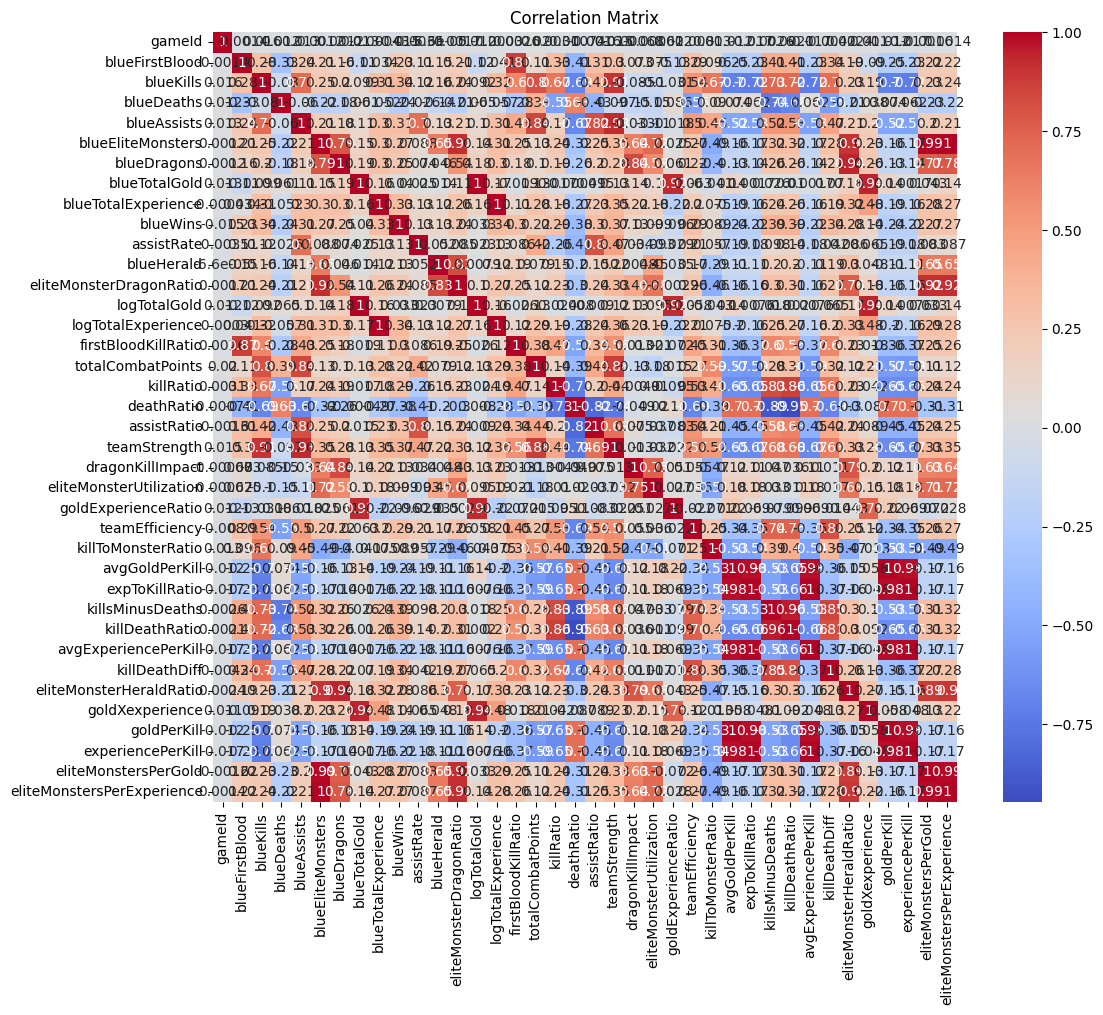

In [7]:
# 特徴量間の相関を観察
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# model

- data

In [8]:
# 無限値が含まれているセルをTrueとするブール型データフレームを作成
inf_df = train.replace([np.inf, -np.inf], np.nan).isna()

# 無限値を含む行と列のインデックスを取得
rows_with_inf = inf_df.any(axis=1)
cols_with_inf = inf_df.any(axis=0)

# 無限値を含む行と列のみを選択
inf_rows_cols_df = train.loc[rows_with_inf, cols_with_inf]

# 結果の表示
print(inf_rows_cols_df)

Empty DataFrame
Columns: []
Index: []


In [9]:
# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# test_drop_gameId = test.drop('gameId', axis=1)

test_drop_gameId_temp = test.drop('gameId', axis=1)

# 特徴量の標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)  # 検証データも同じスケーラーを使用して標準化

# テストデータも同じスケーラーを使用して標準化
test_drop_gameId_scaled = scaler.transform(test_drop_gameId_temp)

# NumPy配列からPandasデータフレームに変換
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
test_drop_gameId = pd.DataFrame(test_drop_gameId_scaled, columns=test_drop_gameId_temp.columns)

- 他model optuna無し

In [10]:
best_params_mlp = {'hidden_layer_sizes': (100,), 'alpha': 0.001}
best_params_svc = {'C': 1.0, 'kernel': 'rbf'}

- optuna_Lgbm

In [11]:
def objective(trial):
    # Optunaで調整するハイパーパラメータ
    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_bin": trial.suggest_int("max_bin", 200, 400),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 0.9),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 0.9),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # クロスバリデーションでのスコア計算
    kf = KFold(n_splits=4, shuffle=True, random_state=71)
    scores = []
    for tr_idx, va_idx in kf.split(X_train):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        lgb_train = lgb.Dataset(tr_x, tr_y)
        lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)

        callbacks = [lgb.early_stopping(100)]
        model = lgb.train(param, lgb_train, num_boost_round=5000, callbacks=callbacks, valid_sets=lgb_eval)
        preds = model.predict(va_x)
        pred_labels = np.rint(preds)
        score = accuracy_score(va_y, pred_labels)
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# 最適なパラメータを取得
best_params_lgbm = study.best_params
print("Best params:", best_params_lgbm)

[I 2024-01-25 11:39:10,711] A new study created in memory with name: no-name-de9b5ebf-bf5c-45b7-a8e0-73c1646d06f2


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.464122
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.460086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.481488
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:13,285] Trial 0 finished with value: 0.77 and parameters: {'num_leaves': 233, 'max_bin': 362, 'learning_rate': 0.03152780975647061, 'bagging_fraction': 0.7719351331786048, 'bagging_freq': 6, 'feature_fraction': 0.45044970231321185, 'min_child_samples': 39}. Best is trial 0 with value: 0.77.


Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.468424
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.458951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.457543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.47733
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:15,677] Trial 1 finished with value: 0.77390625 and parameters: {'num_leaves': 100, 'max_bin': 249, 'learning_rate': 0.023560813633059063, 'bagging_fraction': 0.8248957995143453, 'bagging_freq': 4, 'feature_fraction': 0.7052684476964809, 'min_child_samples': 99}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.465107
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.459249
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.460292
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.478977
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:16,920] Trial 2 finished with value: 0.771875 and parameters: {'num_leaves': 34, 'max_bin': 254, 'learning_rate': 0.07123466513451976, 'bagging_fraction': 0.7404143202463831, 'bagging_freq': 7, 'feature_fraction': 0.6241822770832786, 'min_child_samples': 71}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.467208
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.473908
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.469905
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.485445
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:19,357] Trial 3 finished with value: 0.766875 and parameters: {'num_leaves': 88, 'max_bin': 310, 'learning_rate': 0.058735380515868324, 'bagging_fraction': 0.710887626347318, 'bagging_freq': 3, 'feature_fraction': 0.5202910143424155, 'min_child_samples': 6}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.478252
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.459989
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.455437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.479795


[I 2024-01-25 11:39:20,271] Trial 4 finished with value: 0.770625 and parameters: {'num_leaves': 27, 'max_bin': 288, 'learning_rate': 0.07132214878608621, 'bagging_fraction': 0.5871881951767756, 'bagging_freq': 4, 'feature_fraction': 0.4631049392464196, 'min_child_samples': 92}. Best is trial 1 with value: 0.77390625.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.466111
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	valid_0's binary_logloss: 0.459609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[371]	valid_0's binary_logloss: 0.461788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.480218
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:21,997] Trial 5 finished with value: 0.770625 and parameters: {'num_leaves': 107, 'max_bin': 230, 'learning_rate': 0.025252590989026567, 'bagging_fraction': 0.41473541872874037, 'bagging_freq': 5, 'feature_fraction': 0.8871082192322234, 'min_child_samples': 94}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.467731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.46245
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.460505
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.479294
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:22,987] Trial 6 finished with value: 0.7734375 and parameters: {'num_leaves': 169, 'max_bin': 384, 'learning_rate': 0.08780640462535488, 'bagging_fraction': 0.6155920595260447, 'bagging_freq': 4, 'feature_fraction': 0.8919426374110528, 'min_child_samples': 79}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.468452
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.472915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.466223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.487833
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:27,031] Trial 7 finished with value: 0.773125 and parameters: {'num_leaves': 218, 'max_bin': 323, 'learning_rate': 0.019744153472660425, 'bagging_fraction': 0.8549966466837078, 'bagging_freq': 4, 'feature_fraction': 0.41514866036797193, 'min_child_samples': 20}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.473678
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.49687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.487501
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.499964
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:30,493] Trial 8 finished with value: 0.7603125 and parameters: {'num_leaves': 163, 'max_bin': 274, 'learning_rate': 0.08132914465360828, 'bagging_fraction': 0.5960864190663342, 'bagging_freq': 4, 'feature_fraction': 0.6565279537352311, 'min_child_samples': 6}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.492414
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.470345
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.468102
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.483812
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:34,376] Trial 9 finished with value: 0.7723437499999999 and parameters: {'num_leaves': 197, 'max_bin': 254, 'learning_rate': 0.02366106376881423, 'bagging_fraction': 0.8196967045136689, 'bagging_freq': 3, 'feature_fraction': 0.7994274546420734, 'min_child_samples': 28}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.475906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.462891
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.461406
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.480694
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:36,434] Trial 10 finished with value: 0.7703125000000001 and parameters: {'num_leaves': 78, 'max_bin': 207, 'learning_rate': 0.04280229371865405, 'bagging_fraction': 0.8745334923129876, 'bagging_freq': 1, 'feature_fraction': 0.7465064867684579, 'min_child_samples': 57}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.471252
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.462806
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.461673
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.482163
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:37,758] Trial 11 finished with value: 0.7698437499999999 and parameters: {'num_leaves': 151, 'max_bin': 398, 'learning_rate': 0.09750621312985533, 'bagging_fraction': 0.6620113402391079, 'bagging_freq': 2, 'feature_fraction': 0.8970131355641185, 'min_child_samples': 78}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.469827
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.461649
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.457883
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.479206
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:40,605] Trial 12 finished with value: 0.7703125 and parameters: {'num_leaves': 138, 'max_bin': 343, 'learning_rate': 0.04282864537085599, 'bagging_fraction': 0.8996429591608421, 'bagging_freq': 5, 'feature_fraction': 0.7810126254866453, 'min_child_samples': 99}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.466226
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.46061
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's binary_logloss: 0.45873
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.477852
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:44,134] Trial 13 finished with value: 0.771875 and parameters: {'num_leaves': 175, 'max_bin': 388, 'learning_rate': 0.016414118583115853, 'bagging_fraction': 0.8008810121686072, 'bagging_freq': 5, 'feature_fraction': 0.6914996741239968, 'min_child_samples': 78}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.46612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.464344
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[330]	valid_0's binary_logloss: 0.458999
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	valid_0's binary_logloss: 0.478452
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:49,208] Trial 14 finished with value: 0.77 and parameters: {'num_leaves': 116, 'max_bin': 355, 'learning_rate': 0.012540492519241381, 'bagging_fraction': 0.6852133349330242, 'bagging_freq': 3, 'feature_fraction': 0.831479487048816, 'min_child_samples': 65}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[311]	valid_0's binary_logloss: 0.467837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.461297
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.458991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.478834


[I 2024-01-25 11:39:50,161] Trial 15 finished with value: 0.77 and parameters: {'num_leaves': 71, 'max_bin': 204, 'learning_rate': 0.09799363108720259, 'bagging_fraction': 0.6085557413210914, 'bagging_freq': 2, 'feature_fraction': 0.7307002970423875, 'min_child_samples': 85}. Best is trial 1 with value: 0.77390625.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.46937
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1214]	valid_0's binary_logloss: 0.453754
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1272]	valid_0's binary_logloss: 0.453036
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[782]	valid_0's binary_logloss: 0.473617
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:52,181] Trial 16 finished with value: 0.77359375 and parameters: {'num_leaves': 3, 'max_bin': 254, 'learning_rate': 0.03811515388650303, 'bagging_fraction': 0.761896261612456, 'bagging_freq': 6, 'feature_fraction': 0.8415331107011017, 'min_child_samples': 52}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[789]	valid_0's binary_logloss: 0.464658
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.462483
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.461893
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.477357
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:53,808] Trial 17 finished with value: 0.77296875 and parameters: {'num_leaves': 49, 'max_bin': 240, 'learning_rate': 0.03586131832542056, 'bagging_fraction': 0.7657559124808073, 'bagging_freq': 7, 'feature_fraction': 0.5922712954374504, 'min_child_samples': 45}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.466532
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.463554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.461768
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.47944
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:55,396] Trial 18 finished with value: 0.77015625 and parameters: {'num_leaves': 256, 'max_bin': 282, 'learning_rate': 0.04905808106303838, 'bagging_fraction': 0.821750736364842, 'bagging_freq': 6, 'feature_fraction': 0.7150983631176617, 'min_child_samples': 55}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.468553
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[984]	valid_0's binary_logloss: 0.454071
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[972]	valid_0's binary_logloss: 0.457167
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[858]	valid_0's binary_logloss: 0.473426
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:39:58,660] Trial 19 finished with value: 0.77359375 and parameters: {'num_leaves': 10, 'max_bin': 265, 'learning_rate': 0.011037731844945364, 'bagging_fraction': 0.7302894319407673, 'bagging_freq': 6, 'feature_fraction': 0.8377878858258079, 'min_child_samples': 41}. Best is trial 1 with value: 0.77390625.


Early stopping, best iteration is:
[899]	valid_0's binary_logloss: 0.459606
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1288]	valid_0's binary_logloss: 0.455075
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[702]	valid_0's binary_logloss: 0.461552
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1344]	valid_0's binary_logloss: 0.470612
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:00,663] Trial 20 finished with value: 0.7753125 and parameters: {'num_leaves': 3, 'max_bin': 227, 'learning_rate': 0.030625287521831183, 'bagging_fraction': 0.8549715256372199, 'bagging_freq': 7, 'feature_fraction': 0.6818048785490557, 'min_child_samples': 66}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[1120]	valid_0's binary_logloss: 0.463752
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[721]	valid_0's binary_logloss: 0.453563
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[700]	valid_0's binary_logloss: 0.455041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[803]	valid_0's binary_logloss: 0.472544
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:02,461] Trial 21 finished with value: 0.7748437499999999 and parameters: {'num_leaves': 5, 'max_bin': 223, 'learning_rate': 0.0295808747512052, 'bagging_fraction': 0.8525335970004256, 'bagging_freq': 7, 'feature_fraction': 0.6905654867573703, 'min_child_samples': 48}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[658]	valid_0's binary_logloss: 0.462734
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.461505
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.461074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.48195
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:04,436] Trial 22 finished with value: 0.7698437499999999 and parameters: {'num_leaves': 54, 'max_bin': 225, 'learning_rate': 0.02779216321608403, 'bagging_fraction': 0.8507945223305784, 'bagging_freq': 7, 'feature_fraction': 0.6786989327107278, 'min_child_samples': 63}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.470775
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.461737
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.459804
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.477236
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:05,823] Trial 23 finished with value: 0.773125 and parameters: {'num_leaves': 29, 'max_bin': 219, 'learning_rate': 0.031041842368527695, 'bagging_fraction': 0.8946440494006335, 'bagging_freq': 7, 'feature_fraction': 0.6220955764380734, 'min_child_samples': 33}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.464401
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2226]	valid_0's binary_logloss: 0.469389
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3915]	valid_0's binary_logloss: 0.464928
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3270]	valid_0's binary_logloss: 0.483097
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:10,315] Trial 24 finished with value: 0.7637499999999999 and parameters: {'num_leaves': 2, 'max_bin': 240, 'learning_rate': 0.019914160692654156, 'bagging_fraction': 0.8382595912637776, 'bagging_freq': 5, 'feature_fraction': 0.693993726526747, 'min_child_samples': 49}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[2090]	valid_0's binary_logloss: 0.477787
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.460436
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.459353
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.480471
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:12,383] Trial 25 finished with value: 0.7684374999999999 and parameters: {'num_leaves': 58, 'max_bin': 200, 'learning_rate': 0.025599550251435597, 'bagging_fraction': 0.8007375390150788, 'bagging_freq': 6, 'feature_fraction': 0.7616074223193054, 'min_child_samples': 67}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.467149
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.4747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.47239
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.485611
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:14,800] Trial 26 finished with value: 0.76625 and parameters: {'num_leaves': 91, 'max_bin': 237, 'learning_rate': 0.032963920085201485, 'bagging_fraction': 0.8719766516029469, 'bagging_freq': 5, 'feature_fraction': 0.7208508133327514, 'min_child_samples': 19}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.475862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[630]	valid_0's binary_logloss: 0.459886
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[567]	valid_0's binary_logloss: 0.456517
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[396]	valid_0's binary_logloss: 0.478624
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:18,273] Trial 27 finished with value: 0.77140625 and parameters: {'num_leaves': 24, 'max_bin': 218, 'learning_rate': 0.010306673545006672, 'bagging_fraction': 0.8491929734393078, 'bagging_freq': 7, 'feature_fraction': 0.6541468638007278, 'min_child_samples': 87}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[560]	valid_0's binary_logloss: 0.463206
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.461752
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.456598
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.478858
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:20,566] Trial 28 finished with value: 0.7723437500000001 and parameters: {'num_leaves': 43, 'max_bin': 295, 'learning_rate': 0.018963071508848746, 'bagging_fraction': 0.8987984959728987, 'bagging_freq': 6, 'feature_fraction': 0.5864946046273743, 'min_child_samples': 58}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[197]	valid_0's binary_logloss: 0.467331
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.466624
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.466379
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.486518
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:23,130] Trial 29 finished with value: 0.77359375 and parameters: {'num_leaves': 107, 'max_bin': 261, 'learning_rate': 0.029379403402731586, 'bagging_fraction': 0.7889516976727329, 'bagging_freq': 7, 'feature_fraction': 0.7566772877327864, 'min_child_samples': 35}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.472355
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.462201
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.460629
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.479436
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:24,642] Trial 30 finished with value: 0.7692187500000001 and parameters: {'num_leaves': 129, 'max_bin': 215, 'learning_rate': 0.03601095045545733, 'bagging_fraction': 0.7839877806394104, 'bagging_freq': 2, 'feature_fraction': 0.6842268761027943, 'min_child_samples': 72}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.466856
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[217]	valid_0's binary_logloss: 0.456784
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.456422
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.475338
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:25,750] Trial 31 finished with value: 0.77109375 and parameters: {'num_leaves': 14, 'max_bin': 252, 'learning_rate': 0.041162422147351704, 'bagging_fraction': 0.8275468770889347, 'bagging_freq': 6, 'feature_fraction': 0.7198279053691381, 'min_child_samples': 50}. Best is trial 20 with value: 0.7753125.


Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.464455
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's binary_logloss: 0.453322
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's binary_logloss: 0.453685
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.47371
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:26,968] Trial 32 finished with value: 0.77609375 and parameters: {'num_leaves': 8, 'max_bin': 244, 'learning_rate': 0.036421766699553944, 'bagging_fraction': 0.7595821054930597, 'bagging_freq': 6, 'feature_fraction': 0.7986060732358738, 'min_child_samples': 40}. Best is trial 32 with value: 0.77609375.


Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.463433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.462713
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.459461
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.480182
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:28,615] Trial 33 finished with value: 0.7698437499999999 and parameters: {'num_leaves': 37, 'max_bin': 242, 'learning_rate': 0.03043704035628258, 'bagging_fraction': 0.749853636363929, 'bagging_freq': 7, 'feature_fraction': 0.7846840774952839, 'min_child_samples': 42}. Best is trial 32 with value: 0.77609375.


Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.4687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.460276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.458611
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.472796
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:29,696] Trial 34 finished with value: 0.77671875 and parameters: {'num_leaves': 20, 'max_bin': 270, 'learning_rate': 0.049112521984253935, 'bagging_fraction': 0.8039464512728235, 'bagging_freq': 7, 'feature_fraction': 0.6430444592228313, 'min_child_samples': 24}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.460773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.461175
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.45688
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.475558
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:30,722] Trial 35 finished with value: 0.7740625 and parameters: {'num_leaves': 19, 'max_bin': 275, 'learning_rate': 0.04998691594451171, 'bagging_fraction': 0.8012225686323318, 'bagging_freq': 7, 'feature_fraction': 0.6210785238001443, 'min_child_samples': 24}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.462031
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.470108
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.462627
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.483759
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:32,376] Trial 36 finished with value: 0.77046875 and parameters: {'num_leaves': 70, 'max_bin': 230, 'learning_rate': 0.056724934909259644, 'bagging_fraction': 0.7277557375748246, 'bagging_freq': 6, 'feature_fraction': 0.6623248252644489, 'min_child_samples': 35}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.46971
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.459184
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.460115
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.47363
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:33,392] Trial 37 finished with value: 0.77234375 and parameters: {'num_leaves': 17, 'max_bin': 269, 'learning_rate': 0.05010919581706958, 'bagging_fraction': 0.768827257911401, 'bagging_freq': 7, 'feature_fraction': 0.5683908877121294, 'min_child_samples': 13}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.464094
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.462705
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.459821
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.478643
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:35,097] Trial 38 finished with value: 0.7735937500000001 and parameters: {'num_leaves': 41, 'max_bin': 308, 'learning_rate': 0.03393331308210408, 'bagging_fraction': 0.8630475988578511, 'bagging_freq': 7, 'feature_fraction': 0.6323245335142256, 'min_child_samples': 31}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.467433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.460251
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.456958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.477696
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:36,308] Trial 39 finished with value: 0.7718750000000001 and parameters: {'num_leaves': 31, 'max_bin': 287, 'learning_rate': 0.060893817807611585, 'bagging_fraction': 0.8261438978835518, 'bagging_freq': 6, 'feature_fraction': 0.7042587629370715, 'min_child_samples': 47}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.466642
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.471642
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.466389
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.48413
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:38,504] Trial 40 finished with value: 0.77109375 and parameters: {'num_leaves': 60, 'max_bin': 231, 'learning_rate': 0.02455797863631402, 'bagging_fraction': 0.7014979014376073, 'bagging_freq': 7, 'feature_fraction': 0.6713927716865015, 'min_child_samples': 13}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.47085
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.459195
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.456922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.474593
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:39,636] Trial 41 finished with value: 0.77625 and parameters: {'num_leaves': 20, 'max_bin': 274, 'learning_rate': 0.0467216808191774, 'bagging_fraction': 0.8119915957581977, 'bagging_freq': 7, 'feature_fraction': 0.6373893249283628, 'min_child_samples': 25}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.461442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[927]	valid_0's binary_logloss: 0.456225
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[679]	valid_0's binary_logloss: 0.459819
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[910]	valid_0's binary_logloss: 0.473533
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:41,246] Trial 42 finished with value: 0.77421875 and parameters: {'num_leaves': 3, 'max_bin': 260, 'learning_rate': 0.03964829947540182, 'bagging_fraction': 0.8110922651653212, 'bagging_freq': 7, 'feature_fraction': 0.6488330477651558, 'min_child_samples': 26}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[774]	valid_0's binary_logloss: 0.464749
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.459489
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.458023
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.477337
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:42,304] Trial 43 finished with value: 0.77140625 and parameters: {'num_leaves': 23, 'max_bin': 301, 'learning_rate': 0.046217744290968164, 'bagging_fraction': 0.7838751896511714, 'bagging_freq': 6, 'feature_fraction': 0.7395265528281864, 'min_child_samples': 39}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.46225
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.458158
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.457882
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.474379
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	valid_0's binary_logloss: 0.464068


[I 2024-01-25 11:40:43,290] Trial 44 finished with value: 0.7732812499999999 and parameters: {'num_leaves': 15, 'max_bin': 246, 'learning_rate': 0.044634839500443016, 'bagging_fraction': 0.8397702362372396, 'bagging_freq': 7, 'feature_fraction': 0.5338504349375991, 'min_child_samples': 20}. Best is trial 34 with value: 0.77671875.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.465686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.457751
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.47603
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:44,883] Trial 45 finished with value: 0.77609375 and parameters: {'num_leaves': 36, 'max_bin': 278, 'learning_rate': 0.03494730444851927, 'bagging_fraction': 0.870619345785455, 'bagging_freq': 7, 'feature_fraction': 0.697448754693563, 'min_child_samples': 15}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.46479
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.46397
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.459082
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.478345
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:46,365] Trial 46 finished with value: 0.7765625 and parameters: {'num_leaves': 36, 'max_bin': 279, 'learning_rate': 0.03767037060819215, 'bagging_fraction': 0.8754219531352728, 'bagging_freq': 6, 'feature_fraction': 0.6349967389753374, 'min_child_samples': 13}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.46698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.474398
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.468325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.486
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:48,582] Trial 47 finished with value: 0.7693749999999999 and parameters: {'num_leaves': 83, 'max_bin': 318, 'learning_rate': 0.037693986231502934, 'bagging_fraction': 0.8839806734595893, 'bagging_freq': 5, 'feature_fraction': 0.6444120945048878, 'min_child_samples': 11}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.477382
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.462495
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.457535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.477688
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:49,864] Trial 48 finished with value: 0.77640625 and parameters: {'num_leaves': 37, 'max_bin': 279, 'learning_rate': 0.05445227497905176, 'bagging_fraction': 0.8838509938544477, 'bagging_freq': 6, 'feature_fraction': 0.6158622675814851, 'min_child_samples': 23}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.464521
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.473924
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.464931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.478564
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:51,464] Trial 49 finished with value: 0.7684375000000001 and parameters: {'num_leaves': 62, 'max_bin': 291, 'learning_rate': 0.05288659133566091, 'bagging_fraction': 0.747021277569137, 'bagging_freq': 5, 'feature_fraction': 0.6093709106690738, 'min_child_samples': 7}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.470347
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.466931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.460273
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.480098
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:52,833] Trial 50 finished with value: 0.77171875 and parameters: {'num_leaves': 50, 'max_bin': 304, 'learning_rate': 0.061005188379076467, 'bagging_fraction': 0.8855614739783695, 'bagging_freq': 6, 'feature_fraction': 0.5590678148104208, 'min_child_samples': 23}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.46696
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.462518
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.457591
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.475402
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:54,110] Trial 51 finished with value: 0.7735937500000001 and parameters: {'num_leaves': 33, 'max_bin': 279, 'learning_rate': 0.04169879671147806, 'bagging_fraction': 0.8780207395767473, 'bagging_freq': 6, 'feature_fraction': 0.6365549232080145, 'min_child_samples': 17}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.466799
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.463543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.45936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.478276
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:55,546] Trial 52 finished with value: 0.7759375 and parameters: {'num_leaves': 43, 'max_bin': 270, 'learning_rate': 0.04658034311300923, 'bagging_fraction': 0.8717041584272186, 'bagging_freq': 6, 'feature_fraction': 0.6087412516434326, 'min_child_samples': 27}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.469986
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.462523
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.456718
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.475714
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:56,781] Trial 53 finished with value: 0.7753125 and parameters: {'num_leaves': 27, 'max_bin': 283, 'learning_rate': 0.054819562320216404, 'bagging_fraction': 0.8158568667844206, 'bagging_freq': 5, 'feature_fraction': 0.6587315809456809, 'min_child_samples': 15}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.465978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.468074
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.46174
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.476075
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:40:58,258] Trial 54 finished with value: 0.77328125 and parameters: {'num_leaves': 38, 'max_bin': 332, 'learning_rate': 0.03969773967818311, 'bagging_fraction': 0.8321386194209884, 'bagging_freq': 4, 'feature_fraction': 0.6410829488483938, 'min_child_samples': 9}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.467662
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.473956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.473351
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.487931
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:01,236] Trial 55 finished with value: 0.7704687499999999 and parameters: {'num_leaves': 213, 'max_bin': 263, 'learning_rate': 0.04488752205695554, 'bagging_fraction': 0.853351106651343, 'bagging_freq': 1, 'feature_fraction': 0.6055268231939346, 'min_child_samples': 19}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.476462
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.468878
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.464717
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.484659
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:03,771] Trial 56 finished with value: 0.77453125 and parameters: {'num_leaves': 75, 'max_bin': 295, 'learning_rate': 0.03806960933738744, 'bagging_fraction': 0.8671118562459459, 'bagging_freq': 6, 'feature_fraction': 0.668936465490735, 'min_child_samples': 22}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.472203
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.467664
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.462305
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.481251
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:05,655] Trial 57 finished with value: 0.7704687499999999 and parameters: {'num_leaves': 65, 'max_bin': 275, 'learning_rate': 0.04305515209394933, 'bagging_fraction': 0.8374088182604085, 'bagging_freq': 6, 'feature_fraction': 0.7024382599079398, 'min_child_samples': 31}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.471829
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.466305
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.461597
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.480306
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:07,413] Trial 58 finished with value: 0.7743749999999999 and parameters: {'num_leaves': 47, 'max_bin': 316, 'learning_rate': 0.03343308301605277, 'bagging_fraction': 0.8999692397860164, 'bagging_freq': 7, 'feature_fraction': 0.625984290815134, 'min_child_samples': 28}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.46883
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.476466
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.474526
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.48609
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:09,889] Trial 59 finished with value: 0.76734375 and parameters: {'num_leaves': 95, 'max_bin': 255, 'learning_rate': 0.051646573538149824, 'bagging_fraction': 0.8054799227442847, 'bagging_freq': 3, 'feature_fraction': 0.5846610668209251, 'min_child_samples': 5}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.478399
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.457699
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.45881
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.475676
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:10,954] Trial 60 finished with value: 0.7759375000000001 and parameters: {'num_leaves': 16, 'max_bin': 285, 'learning_rate': 0.04799574372737786, 'bagging_fraction': 0.8675618180565025, 'bagging_freq': 4, 'feature_fraction': 0.7320170616629178, 'min_child_samples': 15}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.464141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.458067
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.457405
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.474791
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:12,201] Trial 61 finished with value: 0.7756249999999999 and parameters: {'num_leaves': 12, 'max_bin': 284, 'learning_rate': 0.046454151028655404, 'bagging_fraction': 0.8711588800978787, 'bagging_freq': 4, 'feature_fraction': 0.70760282697204, 'min_child_samples': 16}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[251]	valid_0's binary_logloss: 0.462644
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.463657
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.457813
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.477033
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:13,304] Trial 62 finished with value: 0.7740625 and parameters: {'num_leaves': 28, 'max_bin': 271, 'learning_rate': 0.053307143442222656, 'bagging_fraction': 0.8473548533646587, 'bagging_freq': 4, 'feature_fraction': 0.7336995440021088, 'min_child_samples': 11}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.464859
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.459078
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.456861
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.474687
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:14,474] Trial 63 finished with value: 0.77390625 and parameters: {'num_leaves': 21, 'max_bin': 291, 'learning_rate': 0.049349996402892574, 'bagging_fraction': 0.8815148779333516, 'bagging_freq': 4, 'feature_fraction': 0.6745477482510097, 'min_child_samples': 23}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.465522
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's binary_logloss: 0.458508
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.459461
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.475506
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:15,656] Trial 64 finished with value: 0.77515625 and parameters: {'num_leaves': 11, 'max_bin': 277, 'learning_rate': 0.035190629905057315, 'bagging_fraction': 0.8165518365783514, 'bagging_freq': 5, 'feature_fraction': 0.8048082897131852, 'min_child_samples': 16}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.4638
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.467082
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.463452
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.485379
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:17,842] Trial 65 finished with value: 0.7740625000000001 and parameters: {'num_leaves': 180, 'max_bin': 296, 'learning_rate': 0.04221260110251224, 'bagging_fraction': 0.8639232548191379, 'bagging_freq': 7, 'feature_fraction': 0.6905350489051642, 'min_child_samples': 37}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.469906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.466327
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.460362
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.483138
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:19,430] Trial 66 finished with value: 0.77234375 and parameters: {'num_leaves': 52, 'max_bin': 264, 'learning_rate': 0.057268224118463544, 'bagging_fraction': 0.8351895888410282, 'bagging_freq': 6, 'feature_fraction': 0.6545794043283704, 'min_child_samples': 32}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.470743
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.466691
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.460296
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.479491
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:20,783] Trial 67 finished with value: 0.77078125 and parameters: {'num_leaves': 33, 'max_bin': 257, 'learning_rate': 0.048182659734070814, 'bagging_fraction': 0.8570230303433992, 'bagging_freq': 3, 'feature_fraction': 0.727599052228359, 'min_child_samples': 8}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.46767
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.456559
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.456876
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[280]	valid_0's binary_logloss: 0.474257
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:21,938] Trial 68 finished with value: 0.77609375 and parameters: {'num_leaves': 10, 'max_bin': 281, 'learning_rate': 0.036929598059799645, 'bagging_fraction': 0.7883889253267177, 'bagging_freq': 5, 'feature_fraction': 0.749487491508053, 'min_child_samples': 25}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[209]	valid_0's binary_logloss: 0.462291
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[297]	valid_0's binary_logloss: 0.454238
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[324]	valid_0's binary_logloss: 0.457497
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.473979
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:23,126] Trial 69 finished with value: 0.7754687499999999 and parameters: {'num_leaves': 9, 'max_bin': 248, 'learning_rate': 0.03761849500385235, 'bagging_fraction': 0.7794779241227425, 'bagging_freq': 5, 'feature_fraction': 0.7494316685240057, 'min_child_samples': 29}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.461282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.473756
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.469923
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.487947
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:26,108] Trial 70 finished with value: 0.768125 and parameters: {'num_leaves': 149, 'max_bin': 269, 'learning_rate': 0.026976664971262963, 'bagging_fraction': 0.7615252836950441, 'bagging_freq': 6, 'feature_fraction': 0.7702202085641019, 'min_child_samples': 25}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.475499
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.458799
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.458914
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.475941
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:27,367] Trial 71 finished with value: 0.773125 and parameters: {'num_leaves': 20, 'max_bin': 280, 'learning_rate': 0.033077419493213425, 'bagging_fraction': 0.7993095758333776, 'bagging_freq': 4, 'feature_fraction': 0.7171978420705711, 'min_child_samples': 20}. Best is trial 34 with value: 0.77671875.


Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.463339
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.461467
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.460056
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.475612
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:28,594] Trial 72 finished with value: 0.77828125 and parameters: {'num_leaves': 25, 'max_bin': 286, 'learning_rate': 0.04001483157979055, 'bagging_fraction': 0.7949111369001886, 'bagging_freq': 5, 'feature_fraction': 0.7406066027736047, 'min_child_samples': 12}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.462173
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.467842
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.462748
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.477319
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:30,150] Trial 73 finished with value: 0.77125 and parameters: {'num_leaves': 38, 'max_bin': 306, 'learning_rate': 0.04000877243116979, 'bagging_fraction': 0.7872541401294992, 'bagging_freq': 5, 'feature_fraction': 0.7520252373774371, 'min_child_samples': 13}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.468636
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.464181
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.461759
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.473706
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:31,276] Trial 74 finished with value: 0.7725 and parameters: {'num_leaves': 26, 'max_bin': 296, 'learning_rate': 0.043405470909662805, 'bagging_fraction': 0.8153585831665434, 'bagging_freq': 7, 'feature_fraction': 0.6784132126632819, 'min_child_samples': 10}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.462408
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.455727
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.461297
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[334]	valid_0's binary_logloss: 0.473776
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:32,341] Trial 75 finished with value: 0.771875 and parameters: {'num_leaves': 8, 'max_bin': 288, 'learning_rate': 0.03652931852354464, 'bagging_fraction': 0.7958313904347624, 'bagging_freq': 6, 'feature_fraction': 0.6963882822390135, 'min_child_samples': 18}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.464146
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.465263
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.462394
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.481458
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:34,241] Trial 76 finished with value: 0.77 and parameters: {'num_leaves': 55, 'max_bin': 266, 'learning_rate': 0.03226375730410322, 'bagging_fraction': 0.7742862439746476, 'bagging_freq': 7, 'feature_fraction': 0.7728354506437014, 'min_child_samples': 43}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.470037
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.46421
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.460771
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.47662
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:35,892] Trial 77 finished with value: 0.77046875 and parameters: {'num_leaves': 44, 'max_bin': 374, 'learning_rate': 0.03535616967068474, 'bagging_fraction': 0.8224112200395413, 'bagging_freq': 5, 'feature_fraction': 0.6372856165218723, 'min_child_samples': 21}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.469287
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1804]	valid_0's binary_logloss: 0.466664
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2060]	valid_0's binary_logloss: 0.468349
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2024]	valid_0's binary_logloss: 0.484841
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:39,033] Trial 78 finished with value: 0.76421875 and parameters: {'num_leaves': 2, 'max_bin': 274, 'learning_rate': 0.028608121500028456, 'bagging_fraction': 0.7579419299729637, 'bagging_freq': 6, 'feature_fraction': 0.6619898631615568, 'min_child_samples': 25}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[2346]	valid_0's binary_logloss: 0.470498
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.461386
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.459023
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.477454
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:40,311] Trial 79 finished with value: 0.7709375 and parameters: {'num_leaves': 32, 'max_bin': 250, 'learning_rate': 0.04061924580150085, 'bagging_fraction': 0.774074612659487, 'bagging_freq': 7, 'feature_fraction': 0.710642898964562, 'min_child_samples': 29}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.465006
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.458456
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.457091
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.477073
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:41,522] Trial 80 finished with value: 0.7734375 and parameters: {'num_leaves': 24, 'max_bin': 312, 'learning_rate': 0.03197899408637459, 'bagging_fraction': 0.8450275812143494, 'bagging_freq': 6, 'feature_fraction': 0.6238374954115258, 'min_child_samples': 35}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.461834
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.458445
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[132]	valid_0's binary_logloss: 0.459433
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.47416
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:42,620] Trial 81 finished with value: 0.77515625 and parameters: {'num_leaves': 16, 'max_bin': 284, 'learning_rate': 0.045153281343633535, 'bagging_fraction': 0.8274760297147278, 'bagging_freq': 4, 'feature_fraction': 0.7362291395161501, 'min_child_samples': 13}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.462299
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.462605
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.459817
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.473314
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:43,673] Trial 82 finished with value: 0.77234375 and parameters: {'num_leaves': 17, 'max_bin': 290, 'learning_rate': 0.047243899732740235, 'bagging_fraction': 0.8858630652817534, 'bagging_freq': 5, 'feature_fraction': 0.7479370009082437, 'min_child_samples': 16}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.460867
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	valid_0's binary_logloss: 0.45733
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.459708
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.473904


[I 2024-01-25 11:41:44,647] Trial 83 finished with value: 0.775 and parameters: {'num_leaves': 10, 'max_bin': 300, 'learning_rate': 0.043585295511907554, 'bagging_fraction': 0.8593599682537338, 'bagging_freq': 5, 'feature_fraction': 0.7643755942701169, 'min_child_samples': 5}. Best is trial 72 with value: 0.77828125.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.462032
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.464452
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.46169
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.475462
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:46,084] Trial 84 finished with value: 0.7703125 and parameters: {'num_leaves': 36, 'max_bin': 279, 'learning_rate': 0.04006144786041805, 'bagging_fraction': 0.7935429499351018, 'bagging_freq': 7, 'feature_fraction': 0.6887383601824962, 'min_child_samples': 23}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.463253
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.463868
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.461951
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.472796
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:47,135] Trial 85 finished with value: 0.7751562499999999 and parameters: {'num_leaves': 24, 'max_bin': 259, 'learning_rate': 0.050579524594121864, 'bagging_fraction': 0.8109226192500285, 'bagging_freq': 6, 'feature_fraction': 0.7242053838548856, 'min_child_samples': 13}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.463423
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.460972
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.460472
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.47571
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:48,582] Trial 86 finished with value: 0.77109375 and parameters: {'num_leaves': 17, 'max_bin': 267, 'learning_rate': 0.03814927676805118, 'bagging_fraction': 0.8438879329724494, 'bagging_freq': 7, 'feature_fraction': 0.7871553676163905, 'min_child_samples': 18}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.464056
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.468813
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.463701
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.482431
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:50,183] Trial 87 finished with value: 0.7732812499999999 and parameters: {'num_leaves': 47, 'max_bin': 273, 'learning_rate': 0.04819272679461994, 'bagging_fraction': 0.8893275109022051, 'bagging_freq': 4, 'feature_fraction': 0.739203732157449, 'min_child_samples': 15}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.470588
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.463402
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.459059
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.47748
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:51,458] Trial 88 finished with value: 0.77265625 and parameters: {'num_leaves': 30, 'max_bin': 281, 'learning_rate': 0.034417780863388765, 'bagging_fraction': 0.876983023736223, 'bagging_freq': 5, 'feature_fraction': 0.6441446254033125, 'min_child_samples': 21}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.467657
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.475452
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.469767
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.486916
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:54,013] Trial 89 finished with value: 0.7685937500000001 and parameters: {'num_leaves': 116, 'max_bin': 290, 'learning_rate': 0.04202965929098886, 'bagging_fraction': 0.7406145140622864, 'bagging_freq': 7, 'feature_fraction': 0.6651068959288187, 'min_child_samples': 26}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.474263
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.455872
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.460041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.474781
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:54,986] Trial 90 finished with value: 0.77296875 and parameters: {'num_leaves': 6, 'max_bin': 301, 'learning_rate': 0.04400955376454737, 'bagging_fraction': 0.830374871190672, 'bagging_freq': 6, 'feature_fraction': 0.7053519172331568, 'min_child_samples': 8}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.464386
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.465843
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.45921
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.478252
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:56,260] Trial 91 finished with value: 0.77453125 and parameters: {'num_leaves': 44, 'max_bin': 286, 'learning_rate': 0.04717770725209429, 'bagging_fraction': 0.8686969318923488, 'bagging_freq': 6, 'feature_fraction': 0.6152974901948429, 'min_child_samples': 27}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.467062
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.466227
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.462133
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.47981
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:57,799] Trial 92 finished with value: 0.7715624999999999 and parameters: {'num_leaves': 66, 'max_bin': 272, 'learning_rate': 0.051817917142107116, 'bagging_fraction': 0.8901677133788111, 'bagging_freq': 6, 'feature_fraction': 0.6047929480278256, 'min_child_samples': 40}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.471574
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.464013
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.45854
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.480774
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:41:59,155] Trial 93 finished with value: 0.77203125 and parameters: {'num_leaves': 41, 'max_bin': 277, 'learning_rate': 0.04548436358791489, 'bagging_fraction': 0.8994118888849127, 'bagging_freq': 6, 'feature_fraction': 0.6312432781112314, 'min_child_samples': 31}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.469291
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.460106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.461092
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.475082
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:42:00,079] Trial 94 finished with value: 0.77203125 and parameters: {'num_leaves': 20, 'max_bin': 234, 'learning_rate': 0.05430524244879158, 'bagging_fraction': 0.859694472833782, 'bagging_freq': 7, 'feature_fraction': 0.6787602507575901, 'min_child_samples': 11}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.463186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.462622
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.457208
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.475045
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:42:01,351] Trial 95 finished with value: 0.77671875 and parameters: {'num_leaves': 34, 'max_bin': 245, 'learning_rate': 0.0491836981363402, 'bagging_fraction': 0.8723935156293617, 'bagging_freq': 7, 'feature_fraction': 0.6495637480491405, 'min_child_samples': 29}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.464145
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.458929
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	valid_0's binary_logloss: 0.456949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.473394


[I 2024-01-25 11:42:02,366] Trial 96 finished with value: 0.7753125 and parameters: {'num_leaves': 13, 'max_bin': 244, 'learning_rate': 0.049639189566694074, 'bagging_fraction': 0.8429287888878887, 'bagging_freq': 7, 'feature_fraction': 0.6490539606697128, 'min_child_samples': 19}. Best is trial 72 with value: 0.77828125.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.461243
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.46268
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.458555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.478121
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:42:03,939] Trial 97 finished with value: 0.7707812500000001 and parameters: {'num_leaves': 36, 'max_bin': 238, 'learning_rate': 0.038398791957367576, 'bagging_fraction': 0.8066044415179543, 'bagging_freq': 7, 'feature_fraction': 0.6574221565573745, 'min_child_samples': 33}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.465462
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.458773
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.457358
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.476192
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:42:05,075] Trial 98 finished with value: 0.7725000000000001 and parameters: {'num_leaves': 28, 'max_bin': 261, 'learning_rate': 0.04161323716308024, 'bagging_fraction': 0.8535173901448414, 'bagging_freq': 7, 'feature_fraction': 0.6294598975877153, 'min_child_samples': 36}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.459782
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.469437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.463609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.482866
Training until validation scores don't improve for 100 rounds


[I 2024-01-25 11:42:06,732] Trial 99 finished with value: 0.77015625 and parameters: {'num_leaves': 54, 'max_bin': 255, 'learning_rate': 0.03604930371631676, 'bagging_fraction': 0.8789708921014596, 'bagging_freq': 3, 'feature_fraction': 0.723983089213415, 'min_child_samples': 24}. Best is trial 72 with value: 0.77828125.


Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.468008
Best params: {'num_leaves': 25, 'max_bin': 286, 'learning_rate': 0.04001483157979055, 'bagging_fraction': 0.7949111369001886, 'bagging_freq': 5, 'feature_fraction': 0.7406066027736047, 'min_child_samples': 12}


- optuna_rf

In [12]:
def objective_random_forest(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 150),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 60)
    }

    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_random_forest, n_trials=100)
best_params_rf = study_rf.best_params

[I 2024-01-25 11:42:06,748] A new study created in memory with name: no-name-ca0f49dd-fd81-4df0-b154-b07e329f8c82
[I 2024-01-25 11:42:10,750] Trial 0 finished with value: 0.7739054090135041 and parameters: {'n_estimators': 133, 'max_depth': 12, 'min_samples_split': 32, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7739054090135041.
[I 2024-01-25 11:42:13,240] Trial 1 finished with value: 0.7675001351107315 and parameters: {'n_estimators': 202, 'max_depth': 6, 'min_samples_split': 34, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.7739054090135041.
[I 2024-01-25 11:42:14,732] Trial 2 finished with value: 0.7681248666284989 and parameters: {'n_estimators': 67, 'max_depth': 26, 'min_samples_split': 97, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.7739054090135041.
[I 2024-01-25 11:42:15,349] Trial 3 finished with value: 0.7620316289462403 and parameters: {'n_estimators': 118, 'max_depth': 22, 'min_samples_split': 140, 'min_samples_leaf': 48}. Best is trial 0 wit

- optuna_SVM

In [13]:
# 1時間でも終わらないので飛ばす


# def objective_svm(trial):
#     params = {
#         "C": trial.suggest_float("C", 0.1, 10.0),
#         "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),
#         "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
#     }

#     clf = svm.SVC(**params)
#     return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

# study_svm = optuna.create_study(direction="maximize")
# study_svm.optimize(objective_svm, n_trials=100)
# best_params_svm = study_svm.best_params

- optuna_LR

In [14]:
def objective_logistic_regression(trial):
    params = {
        "C": trial.suggest_loguniform("C", 1e-4, 10.0),
        "penalty": trial.suggest_categorical("penalty", ["l2", "none"])
    }

    clf = LogisticRegression(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_logistic_regression, n_trials=100)
best_params_lr = study_lr.best_params

[I 2024-01-25 11:44:22,367] A new study created in memory with name: no-name-6fc49f16-892d-45e5-bcd4-cbc3fd59252e
C:\Users\104161\AppData\Local\Temp\ipykernel_9792\3235143177.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-4, 10.0),
[I 2024-01-25 11:44:22,501] Trial 0 finished with value: 0.7140635845016202 and parameters: {'C': 0.0040783227319122345, 'penalty': 'l2'}. Best is trial 0 with value: 0.7140635845016202.
C:\Users\104161\AppData\Local\Temp\ipykernel_9792\3235143177.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-4, 10.0),
[I 2024-01-25 11:44:22,667] Trial 1 finished with value

- optuna_catboost

In [15]:
def objective_catboost(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 300),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"])
    }

    clf = CatBoostClassifier(**params, verbose=0)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=100)
best_params_cb = study_cb.best_params

[I 2024-01-25 11:44:38,703] A new study created in memory with name: no-name-ba9387e5-8be8-4f69-bfc2-22da8a6ebd30
[I 2024-01-25 11:44:45,033] Trial 0 finished with value: 0.7674999154184853 and parameters: {'iterations': 97, 'depth': 10, 'learning_rate': 0.16180983484062855, 'random_strength': 56, 'bagging_temperature': 0.030808783231567327, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.7674999154184853.
[I 2024-01-25 11:44:47,027] Trial 1 finished with value: 0.7665608042962431 and parameters: {'iterations': 142, 'depth': 5, 'learning_rate': 0.24388559415056915, 'random_strength': 60, 'bagging_temperature': 0.04603322833579104, 'od_type': 'Iter'}. Best is trial 0 with value: 0.7674999154184853.
[I 2024-01-25 11:44:51,113] Trial 2 finished with value: 0.7553124148234853 and parameters: {'iterations': 208, 'depth': 8, 'learning_rate': 0.018863605658381074, 'random_strength': 38, 'bagging_temperature': 0.7056587438561559, 'od_type': 'Iter'}. Best is trial 0 with value: 0.76749991

- optuna_XGBoost

In [16]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 25),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0)
    }

    clf = XGBClassifier(**params)
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgboost, n_trials=100)
best_params_xgb = study_xgb.best_params

[I 2024-01-25 11:48:13,455] A new study created in memory with name: no-name-3795412b-e066-4390-a85e-dba5a1af6900
[I 2024-01-25 11:48:14,654] Trial 0 finished with value: 0.7634345836311994 and parameters: {'n_estimators': 83, 'max_depth': 22, 'learning_rate': 0.05773713404647428, 'subsample': 0.5188519957668928, 'colsample_bytree': 0.9702611517564601, 'gamma': 0.6240167438295925}. Best is trial 0 with value: 0.7634345836311994.
[I 2024-01-25 11:48:15,035] Trial 1 finished with value: 0.7723430309884701 and parameters: {'n_estimators': 79, 'max_depth': 5, 'learning_rate': 0.14762600536466475, 'subsample': 0.6730102064907778, 'colsample_bytree': 0.5215354690208074, 'gamma': 0.2840230063639342}. Best is trial 1 with value: 0.7723430309884701.
[I 2024-01-25 11:48:15,902] Trial 2 finished with value: 0.750466223562052 and parameters: {'n_estimators': 248, 'max_depth': 8, 'learning_rate': 0.25763128214821895, 'subsample': 0.6464759680322865, 'colsample_bytree': 0.9367047998242863, 'gamma': 

- study

In [17]:
def predict(X_train, y_train, X_test, mode, X_val):
    preds = []  # バリデーションデータに対する予測結果を格納するリスト
    preds_val = []
    preds_test = []  # テストデータに対する予測結果を格納するリスト

    # クロスバリデーションで予測を実行
    kf = KFold(n_splits=4, shuffle=True, random_state=71)
    for tr_idx, va_idx in kf.split(X_train):
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # モデルを構築
        if mode == 'LightGBM':
            lgb_train = lgb.Dataset(tr_x, tr_y)
            lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)
            # 早期停止コールバックを設定
            callbacks = [lgb.early_stopping(100)]
            model = lgb.train(best_params_lgbm, lgb_train, num_boost_round=5000, callbacks=callbacks, valid_sets=lgb_eval)

        elif mode == 'RandomForest':
            model = RandomForestClassifier(random_state=123, **best_params_rf)
            model = model.fit(tr_x, tr_y)

        elif mode == 'SVM':
            model = SVC(**best_params_svc)
            model = model.fit(tr_x, tr_y)

        elif mode == 'LogisticRegression':
            model = LogisticRegression(**best_params_lr)
            model = model.fit(tr_x, tr_y)

        elif mode == 'CatBoost':
            model = CatBoostClassifier(**best_params_cb)
            model = model.fit(tr_x, tr_y)

        elif mode == 'XGBoost':
            model = xgb.XGBClassifier(**best_params_xgb)
            model = model.fit(tr_x, tr_y)

        elif mode == 'MLP':
            model = MLPClassifier(**best_params_mlp)
            model = model.fit(tr_x, tr_y)
            

        

        # バリデーションデータに対する予測
        pred = model.predict(va_x)
        preds.append(pred)

        pred_val = model.predict(X_val)
        preds_val.append(pred_val)

        # テストデータに対する予測
        pred_test = model.predict(X_test)
        preds_test.append(pred_test)

    # バリデーションデータに対する予測結果を連結、元の順序に戻す
    preds = np.concatenate(preds, axis=0)

    # valに対する平均予測値を取得
    preds_val = np.mean(preds_val, axis=0)

    # テストデータに対する平均予測値を取得
    preds_test = np.mean(preds_test, axis=0)

    return preds, preds_val, preds_test

- base model

In [18]:
# 異なるモデルのベースモデルを定義
base_models = [
    ('LightGBM', lgb.LGBMClassifier(**best_params_lgbm)),
    ('RandomForest', RandomForestClassifier(random_state=123, **best_params_rf)),
    ('LogisticRegression', LogisticRegression(**best_params_lr)),
    # ('XGBoost', XGBClassifier(**best_params_xgb)),
    ('CatBoost', CatBoostClassifier(**best_params_cb)),
    ('MLP', MLPClassifier(**best_params_mlp)),
    # ('SVM', SVC(**best_params_svc))
]

- base調査【各1個ずつ除外】

In [19]:
# 各ベースモデルを一つずつ除外してパフォーマンスを評価

accuracy_check = []
model_name_check = []

for name, model in base_models:
    # 現在のモデルを除外
    current_models = [m for m in base_models if m[0] != name]

    # 新しいスタッキングモデル
    stacking_model = StackingClassifier(estimators=current_models, final_estimator=CatBoostClassifier(**best_params_cb))
    stacking_model.fit(X_train, y_train)
    predictions = stacking_model.predict(X_val)
    accuracy_check.append(accuracy_score(y_val, predictions))
    model_name_check.append(name)

for i in range(len(model_name_check)):
    print(f"{model_name_check[i]}を除外した時の精度: {accuracy_check[i]}")

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6763275	total: 131ms	remaining: 37.6s
1:	learn: 0.6670453	total: 134ms	remaining: 19.2s
2:	learn: 0.6536508	total: 138ms	remaining: 13.1s
3:	learn: 0.6487897	total: 142ms	remaining: 10.1s
4:	learn: 0.6388359	total: 146ms	remaining: 8.26s
5:	learn: 0.6292112	total: 149ms	remaining: 7.03s
6:	learn: 0.6283782	total: 152ms	remaining: 6.12s
7:	learn: 0.6243013	total: 155ms	remaining: 5.43s
8:	learn: 0.6184068	total: 158ms	remaining: 4.9s
9:	learn: 0.6141966	total: 161ms	remaining: 4.48s
10:	learn: 0.6095245	total: 165ms	remaining: 4.14s
11:	learn: 0.6031379	total: 168ms	remaining: 3.85s
12:	learn: 0.6009471	total: 170ms	remaining: 3.6s
13:	learn: 0.5990320	total: 174ms	remaining: 3.4s
14:	learn: 0.5959823	total: 177ms	remaining: 3.22s
15:	learn: 0.5942379	total: 180ms	remaining: 3.06s
16:	learn: 0.5940842	total: 182ms	remaining: 2.9s
17:	learn: 0.5916766	total: 185ms	remaining: 2.77s
18:	learn: 0.5869199	total: 188ms	remaining: 2.67s
19:	learn: 0.5860958	total: 192ms	remaining: 

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://s

0:	learn: 0.6840734	total: 5ms	remaining: 1.44s
1:	learn: 0.6727893	total: 8.2ms	remaining: 1.17s
2:	learn: 0.6663038	total: 12.2ms	remaining: 1.16s
3:	learn: 0.6541719	total: 15.2ms	remaining: 1.08s
4:	learn: 0.6485861	total: 18.7ms	remaining: 1.05s
5:	learn: 0.6441862	total: 21.8ms	remaining: 1.02s
6:	learn: 0.6400551	total: 25ms	remaining: 1s
7:	learn: 0.6367642	total: 29.1ms	remaining: 1.02s
8:	learn: 0.6159958	total: 32.6ms	remaining: 1.01s
9:	learn: 0.6073614	total: 35.8ms	remaining: 995ms
10:	learn: 0.6026792	total: 39.7ms	remaining: 1s
11:	learn: 0.5907262	total: 43.6ms	remaining: 1s
12:	learn: 0.5872354	total: 47ms	remaining: 995ms
13:	learn: 0.5852572	total: 49.9ms	remaining: 976ms
14:	learn: 0.5757628	total: 52.9ms	remaining: 963ms
15:	learn: 0.5744197	total: 55.9ms	remaining: 950ms
16:	learn: 0.5735281	total: 59.4ms	remaining: 947ms
17:	learn: 0.5724348	total: 62.8ms	remaining: 942ms
18:	learn: 0.5707520	total: 65.7ms	remaining: 930ms
19:	learn: 0.5676086	total: 68.6ms	rema

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

0:	learn: 0.6542747	total: 3.32ms	remaining: 952ms
1:	learn: 0.6269002	total: 6.32ms	remaining: 903ms
2:	learn: 0.6024497	total: 8.95ms	remaining: 851ms
3:	learn: 0.5830776	total: 12.1ms	remaining: 861ms
4:	learn: 0.5671223	total: 15.6ms	remaining: 882ms
5:	learn: 0.5554676	total: 18.2ms	remaining: 856ms
6:	learn: 0.5441375	total: 20.9ms	remaining: 838ms
7:	learn: 0.5350997	total: 23.4ms	remaining: 819ms
8:	learn: 0.5245227	total: 25.9ms	remaining: 804ms
9:	learn: 0.5154714	total: 28.6ms	remaining: 795ms
10:	learn: 0.5075996	total: 31.1ms	remaining: 784ms
11:	learn: 0.5009883	total: 33.9ms	remaining: 780ms
12:	learn: 0.4966238	total: 37.3ms	remaining: 789ms
13:	learn: 0.4926945	total: 39.7ms	remaining: 778ms
14:	learn: 0.4902517	total: 42ms	remaining: 764ms
15:	learn: 0.4879543	total: 44.6ms	remaining: 758ms
16:	learn: 0.4864177	total: 47.2ms	remaining: 752ms
17:	learn: 0.4840927	total: 49.3ms	remaining: 740ms
18:	learn: 0.4814691	total: 51.7ms	remaining: 732ms
19:	learn: 0.4806622	tot

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6763275	total: 5.99ms	remaining: 1.72s
1:	learn: 0.6670453	total: 9.9ms	remaining: 1.42s
2:	learn: 0.6536508	total: 13.5ms	remaining: 1.28s
3:	learn: 0.6487897	total: 17.3ms	remaining: 1.23s
4:	learn: 0.6388359	total: 21.3ms	remaining: 1.21s
5:	learn: 0.6292112	total: 25.2ms	remaining: 1.19s
6:	learn: 0.6283782	total: 29.4ms	remaining: 1.18s
7:	learn: 0.6243013	total: 34.2ms	remaining: 1.2s
8:	learn: 0.6184068	total: 37.8ms	remaining: 1.17s
9:	learn: 0.6141966	total: 41.4ms	remaining: 1.15s
10:	learn: 0.6095245	total: 45.5ms	remaining: 1.15s
11:	learn: 0.6031379	total: 49.4ms	remaining: 1.14s
12:	learn: 0.6009471	total: 52.9ms	remaining: 1.12s
13:	learn: 0.5990320	total: 56.3ms	remaining: 1.1s
14:	learn: 0.5959823	total: 60.9ms	remaining: 1.11s
15:	learn: 0.5942379	total: 64.4ms	remaining: 1.09s
16:	learn: 0.5940842	total: 68.2ms	remaining: 1.09s
17:	learn: 0.5916766	total: 72.3ms	remaining: 1.08s
18:	learn: 0.5869199	total: 76.5ms	remaining: 1.08s
19:	learn: 0.5860958	tota

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6840734	total: 4.92ms	remaining: 1.41s
1:	learn: 0.6727893	total: 8.27ms	remaining: 1.18s
2:	learn: 0.6663038	total: 11.8ms	remaining: 1.12s
3:	learn: 0.6541719	total: 14.5ms	remaining: 1.03s
4:	learn: 0.6485861	total: 17.5ms	remaining: 990ms
5:	learn: 0.6441862	total: 20.9ms	remaining: 985ms
6:	learn: 0.6400551	total: 23.8ms	remaining: 956ms
7:	learn: 0.6367642	total: 26.9ms	remaining: 941ms
8:	learn: 0.6159958	total: 29.9ms	remaining: 927ms
9:	learn: 0.6073614	total: 32.9ms	remaining: 916ms
10:	learn: 0.6026792	total: 36.4ms	remaining: 917ms
11:	learn: 0.5907262	total: 39.5ms	remaining: 908ms
12:	learn: 0.5872354	total: 42.3ms	remaining: 894ms
13:	learn: 0.5852572	total: 45.4ms	remaining: 889ms
14:	learn: 0.5757628	total: 48.3ms	remaining: 880ms
15:	learn: 0.5744197	total: 51.4ms	remaining: 873ms
16:	learn: 0.5735281	total: 54.6ms	remaining: 870ms
17:	learn: 0.5724348	total: 57.5ms	remaining: 863ms
18:	learn: 0.5707520	total: 60.5ms	remaining: 857ms
19:	learn: 0.5676086	t

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

0:	learn: 0.6540038	total: 3.55ms	remaining: 1.02s
1:	learn: 0.6268587	total: 6.51ms	remaining: 931ms
2:	learn: 0.6021744	total: 8.88ms	remaining: 843ms
3:	learn: 0.5829296	total: 11.1ms	remaining: 787ms
4:	learn: 0.5663651	total: 14ms	remaining: 795ms
5:	learn: 0.5516692	total: 16.5ms	remaining: 776ms
6:	learn: 0.5382231	total: 18.9ms	remaining: 759ms
7:	learn: 0.5295333	total: 21.3ms	remaining: 744ms
8:	learn: 0.5215493	total: 23.7ms	remaining: 734ms
9:	learn: 0.5130943	total: 26.2ms	remaining: 728ms
10:	learn: 0.5047337	total: 29.3ms	remaining: 738ms
11:	learn: 0.4986646	total: 32ms	remaining: 735ms
12:	learn: 0.4948472	total: 34.7ms	remaining: 734ms
13:	learn: 0.4914338	total: 37.3ms	remaining: 730ms
14:	learn: 0.4874379	total: 39.8ms	remaining: 725ms
15:	learn: 0.4851469	total: 42.5ms	remaining: 723ms
16:	learn: 0.4828559	total: 45.4ms	remaining: 724ms
17:	learn: 0.4804601	total: 48.1ms	remaining: 722ms
18:	learn: 0.4791582	total: 50.5ms	remaining: 715ms
19:	learn: 0.4769627	total

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

0:	learn: 0.6540038	total: 3.76ms	remaining: 1.08s
1:	learn: 0.6266422	total: 6.72ms	remaining: 961ms
2:	learn: 0.6012103	total: 9.2ms	remaining: 874ms
3:	learn: 0.5807195	total: 12.2ms	remaining: 863ms
4:	learn: 0.5622070	total: 14.7ms	remaining: 834ms
5:	learn: 0.5481322	total: 17.4ms	remaining: 817ms
6:	learn: 0.5369668	total: 20.4ms	remaining: 820ms
7:	learn: 0.5262527	total: 23.6ms	remaining: 825ms
8:	learn: 0.5177069	total: 26ms	remaining: 805ms
9:	learn: 0.5093512	total: 28.4ms	remaining: 789ms
10:	learn: 0.5035748	total: 30.7ms	remaining: 773ms
11:	learn: 0.4981741	total: 33.2ms	remaining: 764ms
12:	learn: 0.4930444	total: 36.2ms	remaining: 765ms
13:	learn: 0.4888297	total: 39.2ms	remaining: 766ms
14:	learn: 0.4854830	total: 41.5ms	remaining: 756ms
15:	learn: 0.4824442	total: 44ms	remaining: 748ms
16:	learn: 0.4808233	total: 46.6ms	remaining: 742ms
17:	learn: 0.4788300	total: 49ms	remaining: 735ms
18:	learn: 0.4766599	total: 51.9ms	remaining: 734ms
19:	learn: 0.4742804	total: 5

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6560674	total: 3.6ms	remaining: 1.03s
1:	learn: 0.6307643	total: 6.55ms	remaining: 937ms
2:	learn: 0.6083115	total: 8.86ms	remaining: 842ms
3:	learn: 0.5861882	total: 11.2ms	remaining: 798ms
4:	learn: 0.5673641	total: 13.6ms	remaining: 768ms
5:	learn: 0.5529544	total: 15.7ms	remaining: 738ms
6:	learn: 0.5384294	total: 17.9ms	remaining: 717ms
7:	learn: 0.5274620	total: 20.2ms	remaining: 707ms
8:	learn: 0.5176125	total: 22.5ms	remaining: 698ms
9:	learn: 0.5113645	total: 24.5ms	remaining: 682ms
10:	learn: 0.5054992	total: 26.6ms	remaining: 670ms
11:	learn: 0.4996729	total: 28.7ms	remaining: 661ms
12:	learn: 0.4967426	total: 30.8ms	remaining: 651ms
13:	learn: 0.4925771	total: 33ms	remaining: 645ms
14:	learn: 0.4883935	total: 35.5ms	remaining: 647ms
15:	learn: 0.4858537	total: 38.5ms	remaining: 654ms
16:	learn: 0.4841093	total: 40.6ms	remaining: 648ms
17:	learn: 0.4812232	total: 43.3ms	remaining: 650ms
18:	learn: 0.4786204	total: 45.6ms	remaining: 645ms
19:	learn: 0.4763543	tota

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6763275	total: 4.59ms	remaining: 1.32s
1:	learn: 0.6670453	total: 7.92ms	remaining: 1.13s
2:	learn: 0.6536508	total: 11.3ms	remaining: 1.08s
3:	learn: 0.6487897	total: 14.6ms	remaining: 1.03s
4:	learn: 0.6388359	total: 17.8ms	remaining: 1.01s
5:	learn: 0.6292112	total: 21.4ms	remaining: 1.01s
6:	learn: 0.6283782	total: 24.6ms	remaining: 990ms
7:	learn: 0.6243013	total: 27.6ms	remaining: 968ms
8:	learn: 0.6184068	total: 30.8ms	remaining: 956ms
9:	learn: 0.6141966	total: 34ms	remaining: 944ms
10:	learn: 0.6095245	total: 38.5ms	remaining: 970ms
11:	learn: 0.6031379	total: 42.4ms	remaining: 975ms
12:	learn: 0.6009471	total: 45.7ms	remaining: 966ms
13:	learn: 0.5990320	total: 49ms	remaining: 958ms
14:	learn: 0.5959823	total: 53.1ms	remaining: 967ms
15:	learn: 0.5942379	total: 56.3ms	remaining: 957ms
16:	learn: 0.5940842	total: 59.6ms	remaining: 950ms
17:	learn: 0.5916766	total: 62.5ms	remaining: 938ms
18:	learn: 0.5869199	total: 65.8ms	remaining: 931ms
19:	learn: 0.5860958	total

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6840734	total: 4.24ms	remaining: 1.22s
1:	learn: 0.6727893	total: 7.26ms	remaining: 1.04s
2:	learn: 0.6663038	total: 10.6ms	remaining: 1s
3:	learn: 0.6541719	total: 13.6ms	remaining: 964ms
4:	learn: 0.6485861	total: 16.4ms	remaining: 930ms
5:	learn: 0.6441862	total: 19.3ms	remaining: 905ms
6:	learn: 0.6400551	total: 21.8ms	remaining: 875ms
7:	learn: 0.6367642	total: 25ms	remaining: 877ms
8:	learn: 0.6159958	total: 28.3ms	remaining: 876ms
9:	learn: 0.6073614	total: 31.5ms	remaining: 875ms
10:	learn: 0.6026792	total: 35ms	remaining: 881ms
11:	learn: 0.5907262	total: 37.7ms	remaining: 868ms
12:	learn: 0.5872354	total: 40.3ms	remaining: 852ms
13:	learn: 0.5852572	total: 43.3ms	remaining: 848ms
14:	learn: 0.5757628	total: 46.1ms	remaining: 839ms
15:	learn: 0.5744197	total: 49.7ms	remaining: 846ms
16:	learn: 0.5735281	total: 52.5ms	remaining: 837ms
17:	learn: 0.5724348	total: 55.2ms	remaining: 828ms
18:	learn: 0.5707520	total: 57.7ms	remaining: 817ms
19:	learn: 0.5676086	total: 6

- base 調査【全てで実施】

In [20]:
# 全てのベースモデルを含むスタッキングモデルのパフォーマンスを評価
stacking_model = StackingClassifier(estimators=base_models, final_estimator=CatBoostClassifier(**best_params_cb))
stacking_model.fit(X_train, y_train)
predictions = stacking_model.predict(X_val)
accuracy_full = accuracy_score(y_val, predictions)

# 全てのモデルを含む元のスタッキングモデルの精度
print(f"全てのモデルを含むスタッキングモデルの精度: {accuracy_full}")

[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 3144, number of negative: 3256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6763275	total: 6.88ms	remaining: 1.97s
1:	learn: 0.6670453	total: 10.2ms	remaining: 1.46s
2:	learn: 0.6536508	total: 13.3ms	remaining: 1.26s
3:	learn: 0.6487897	total: 16.1ms	remaining: 1.14s
4:	learn: 0.6388359	total: 19ms	remaining: 1.07s
5:	learn: 0.6292112	total: 22.5ms	remaining: 1.06s
6:	learn: 0.6283782	total: 25.2ms	remaining: 1.01s
7:	learn: 0.6243013	total: 27.9ms	remaining: 976ms
8:	learn: 0.6184068	total: 30.8ms	remaining: 954ms
9:	learn: 0.6141966	total: 33.6ms	remaining: 934ms
10:	learn: 0.6095245	total: 37.3ms	remaining: 939ms
11:	learn: 0.6031379	total: 40.3ms	remaining: 926ms
12:	learn: 0.6009471	total: 43.3ms	remaining: 915ms
13:	learn: 0.5990320	total: 46.5ms	remaining: 910ms
14:	learn: 0.5959823	total: 49.6ms	remaining: 902ms
15:	learn: 0.5942379	total: 53.6ms	remaining: 912ms
16:	learn: 0.5940842	total: 57ms	remaining: 909ms
17:	learn: 0.5916766	total: 60ms	remaining: 901ms
18:	learn: 0.5869199	total: 63.1ms	remaining: 894ms
19:	learn: 0.5860958	total: 

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 2515, number of negative: 2605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6840734	total: 4.12ms	remaining: 1.18s
1:	learn: 0.6727893	total: 6.87ms	remaining: 982ms
2:	learn: 0.6663038	total: 9.82ms	remaining: 933ms
3:	learn: 0.6541719	total: 13ms	remaining: 925ms
4:	learn: 0.6485861	total: 15.8ms	remaining: 894ms
5:	learn: 0.6441862	total: 18.3ms	remaining: 859ms
6:	learn: 0.6400551	total: 21.1ms	remaining: 846ms
7:	learn: 0.6367642	total: 23.8ms	remaining: 834ms
8:	learn: 0.6159958	total: 27.3ms	remaining: 848ms
9:	learn: 0.6073614	total: 30.1ms	remaining: 837ms
10:	learn: 0.6026792	total: 32.9ms	remaining: 828ms
11:	learn: 0.5907262	total: 35.7ms	remaining: 821ms
12:	learn: 0.5872354	total: 38.5ms	remaining: 814ms
13:	learn: 0.5852572	total: 41.5ms	remaining: 812ms
14:	learn: 0.5757628	total: 45.5ms	remaining: 829ms
15:	learn: 0.5744197	total: 48.3ms	remaining: 820ms
16:	learn: 0.5735281	total: 51.1ms	remaining: 814ms
17:	learn: 0.5724348	total: 53.8ms	remaining: 807ms
18:	learn: 0.5707520	total: 56.5ms	remaining: 800ms
19:	learn: 0.5676086	tot

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

0:	learn: 0.6575455	total: 3.51ms	remaining: 1.01s
1:	learn: 0.6271153	total: 6.58ms	remaining: 942ms
2:	learn: 0.6053563	total: 9.05ms	remaining: 860ms
3:	learn: 0.5806837	total: 11.4ms	remaining: 807ms
4:	learn: 0.5629769	total: 13.9ms	remaining: 787ms
5:	learn: 0.5468001	total: 16.3ms	remaining: 766ms
6:	learn: 0.5358443	total: 18.4ms	remaining: 740ms
7:	learn: 0.5248796	total: 22.2ms	remaining: 778ms
8:	learn: 0.5152399	total: 24.2ms	remaining: 752ms
9:	learn: 0.5080731	total: 26.6ms	remaining: 739ms
10:	learn: 0.5024590	total: 28.9ms	remaining: 729ms
11:	learn: 0.4972591	total: 31.1ms	remaining: 715ms
12:	learn: 0.4928582	total: 33.3ms	remaining: 703ms
13:	learn: 0.4889774	total: 35.9ms	remaining: 704ms
14:	learn: 0.4857521	total: 39.2ms	remaining: 713ms
15:	learn: 0.4829051	total: 41.2ms	remaining: 701ms
16:	learn: 0.4808442	total: 43.7ms	remaining: 697ms
17:	learn: 0.4785275	total: 45.9ms	remaining: 689ms
18:	learn: 0.4765869	total: 48.2ms	remaining: 683ms
19:	learn: 0.4751981	t

- stackingClassifier設定しているのにトレーニング結果の予測結果を特徴として追加して2重疑惑

In [21]:
# # スタッキングモデルを定義（ここではロジスティック回帰を使用）
# stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(**best_params_lr))


# # ベースモデルのトレーニングと予測
# for model_name, model in base_models:
#     preds_train, preds_val, preds_test = predict(X_train, y_train, test_drop_gameId, model_name, X_val)  # テストデータを使って予測
#     # トレーニングデータの予測結果を特徴として追加
#     X_train[model_name] = preds_train
#     X_val[model_name] = preds_val
#     test_drop_gameId[model_name] = preds_test  # テストデータの特徴量として追加

# # 特徴データセットの結合
# X_combined = pd.concat([X_train, X_val], axis=0)

# # ラベルデータセットの結合
# y_combined = pd.concat([y_train, y_val], axis=0)

# # スタッキングモデルのトレーニング
# stacking_model.fit(X_train, y_train)

- y_val accuracy確認

In [22]:
# X_valデータでモデルの精度を評価
y_val_pred = stacking_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Validation Accuracy: 0.795


- CV実施

In [23]:
# クロスバリデーションの実行
scores = cross_val_score(stacking_model, X, y, cv=5, scoring='accuracy')

[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 3148, number of negative: 3252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001237 seconds.
You can s

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6762737	total: 5.36ms	remaining: 1.54s
1:	learn: 0.6661114	total: 9.19ms	remaining: 1.31s
2:	learn: 0.6527168	total: 14.1ms	remaining: 1.34s
3:	learn: 0.6480667	total: 17.7ms	remaining: 1.25s
4:	learn: 0.6375166	total: 21.7ms	remaining: 1.23s
5:	learn: 0.6278055	total: 25.3ms	remaining: 1.19s
6:	learn: 0.6269672	total: 29.6ms	remaining: 1.19s
7:	learn: 0.6224769	total: 33.3ms	remaining: 1.17s
8:	learn: 0.6167073	total: 37ms	remaining: 1.15s
9:	learn: 0.6122081	total: 40.5ms	remaining: 1.13s
10:	learn: 0.6072558	total: 44.7ms	remaining: 1.13s
11:	learn: 0.6004207	total: 48.6ms	remaining: 1.12s
12:	learn: 0.5952734	total: 52.2ms	remaining: 1.1s
13:	learn: 0.5829359	total: 55.8ms	remaining: 1.09s
14:	learn: 0.5795550	total: 60ms	remaining: 1.09s
15:	learn: 0.5791976	total: 63.6ms	remaining: 1.08s
16:	learn: 0.5778034	total: 67.2ms	remaining: 1.07s
17:	learn: 0.5752643	total: 70.4ms	remaining: 1.06s
18:	learn: 0.5746353	total: 72.9ms	remaining: 1.03s
19:	learn: 0.5715730	total:

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6767496	total: 4.93ms	remaining: 1.41s
1:	learn: 0.6663573	total: 7.95ms	remaining: 1.14s
2:	learn: 0.6548301	total: 10.6ms	remaining: 1s
3:	learn: 0.6458302	total: 13.6ms	remaining: 964ms
4:	learn: 0.6354725	total: 17.1ms	remaining: 968ms
5:	learn: 0.6247047	total: 19.8ms	remaining: 931ms
6:	learn: 0.6183157	total: 22.5ms	remaining: 903ms
7:	learn: 0.6111800	total: 25.2ms	remaining: 883ms
8:	learn: 0.6055108	total: 28.1ms	remaining: 872ms
9:	learn: 0.6010348	total: 35.8ms	remaining: 995ms
10:	learn: 0.5982191	total: 40ms	remaining: 1.01s
11:	learn: 0.5826593	total: 43.5ms	remaining: 1s
12:	learn: 0.5805542	total: 47.2ms	remaining: 999ms
13:	learn: 0.5795753	total: 50.1ms	remaining: 980ms
14:	learn: 0.5774411	total: 53ms	remaining: 965ms
15:	learn: 0.5756945	total: 55.9ms	remaining: 950ms
16:	learn: 0.5754638	total: 59.6ms	remaining: 951ms
17:	learn: 0.5732623	total: 63.3ms	remaining: 949ms
18:	learn: 0.5702972	total: 66.4ms	remaining: 940ms
19:	learn: 0.5695269	total: 69.1

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6757297	total: 5.82ms	remaining: 1.67s
1:	learn: 0.6656074	total: 10.6ms	remaining: 1.52s
2:	learn: 0.6559109	total: 14.1ms	remaining: 1.34s
3:	learn: 0.6472754	total: 17.6ms	remaining: 1.25s
4:	learn: 0.6367400	total: 21.2ms	remaining: 1.2s
5:	learn: 0.6266335	total: 26.2ms	remaining: 1.23s
6:	learn: 0.6208656	total: 30ms	remaining: 1.2s
7:	learn: 0.6144982	total: 33.6ms	remaining: 1.18s
8:	learn: 0.6087947	total: 37.8ms	remaining: 1.17s
9:	learn: 0.6054132	total: 41.5ms	remaining: 1.15s
10:	learn: 0.6005452	total: 45.5ms	remaining: 1.15s
11:	learn: 0.6001947	total: 49.9ms	remaining: 1.15s
12:	learn: 0.5978208	total: 53.2ms	remaining: 1.13s
13:	learn: 0.5944512	total: 57.7ms	remaining: 1.13s
14:	learn: 0.5890538	total: 61.4ms	remaining: 1.12s
15:	learn: 0.5881593	total: 64.7ms	remaining: 1.1s
16:	learn: 0.5776899	total: 69.1ms	remaining: 1.1s
17:	learn: 0.5742616	total: 73ms	remaining: 1.09s
18:	learn: 0.5735054	total: 76.8ms	remaining: 1.09s
19:	learn: 0.5721484	total: 80

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6768061	total: 5.63ms	remaining: 1.62s
1:	learn: 0.6663748	total: 8.84ms	remaining: 1.26s
2:	learn: 0.6557848	total: 11.7ms	remaining: 1.11s
3:	learn: 0.6515003	total: 14.1ms	remaining: 998ms
4:	learn: 0.6389970	total: 17.6ms	remaining: 996ms
5:	learn: 0.6320183	total: 20.4ms	remaining: 958ms
6:	learn: 0.6276726	total: 23ms	remaining: 922ms
7:	learn: 0.6254781	total: 25.7ms	remaining: 901ms
8:	learn: 0.6218180	total: 28.5ms	remaining: 884ms
9:	learn: 0.6167900	total: 31.5ms	remaining: 876ms
10:	learn: 0.6139581	total: 34.6ms	remaining: 871ms
11:	learn: 0.6111404	total: 37.3ms	remaining: 858ms
12:	learn: 0.6089211	total: 40.1ms	remaining: 848ms
13:	learn: 0.6063816	total: 42.9ms	remaining: 840ms
14:	learn: 0.6025822	total: 45.8ms	remaining: 833ms
15:	learn: 0.5939857	total: 49.4ms	remaining: 840ms
16:	learn: 0.5913118	total: 52.3ms	remaining: 833ms
17:	learn: 0.5890002	total: 55.1ms	remaining: 827ms
18:	learn: 0.5866913	total: 58ms	remaining: 821ms
19:	learn: 0.5853634	total

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6769037	total: 5.41ms	remaining: 1.55s
1:	learn: 0.6671633	total: 8.58ms	remaining: 1.23s
2:	learn: 0.6563914	total: 11.5ms	remaining: 1.09s
3:	learn: 0.6517494	total: 14.1ms	remaining: 1s
4:	learn: 0.6417398	total: 18.2ms	remaining: 1.03s
5:	learn: 0.6313503	total: 21ms	remaining: 987ms
6:	learn: 0.6302906	total: 23.6ms	remaining: 949ms
7:	learn: 0.6256663	total: 26.3ms	remaining: 921ms
8:	learn: 0.6198360	total: 28.9ms	remaining: 895ms
9:	learn: 0.6098053	total: 32ms	remaining: 889ms
10:	learn: 0.6059272	total: 35.5ms	remaining: 895ms
11:	learn: 0.5901976	total: 38.5ms	remaining: 885ms
12:	learn: 0.5882064	total: 41.2ms	remaining: 873ms
13:	learn: 0.5865799	total: 44.1ms	remaining: 863ms
14:	learn: 0.5840653	total: 46.7ms	remaining: 851ms
15:	learn: 0.5823676	total: 49.8ms	remaining: 847ms
16:	learn: 0.5822369	total: 52.6ms	remaining: 839ms
17:	learn: 0.5800358	total: 55.4ms	remaining: 831ms
18:	learn: 0.5759302	total: 58.4ms	remaining: 827ms
19:	learn: 0.5750160	total: 6

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6778870	total: 4.14ms	remaining: 1.19s
1:	learn: 0.6679935	total: 7.25ms	remaining: 1.04s
2:	learn: 0.6548868	total: 10.7ms	remaining: 1.01s
3:	learn: 0.6501576	total: 13.5ms	remaining: 960ms
4:	learn: 0.6402621	total: 16.2ms	remaining: 918ms
5:	learn: 0.6335804	total: 18.9ms	remaining: 889ms
6:	learn: 0.6326859	total: 21.5ms	remaining: 863ms
7:	learn: 0.6280762	total: 25.3ms	remaining: 885ms
8:	learn: 0.6221526	total: 28.3ms	remaining: 877ms
9:	learn: 0.6124295	total: 31.6ms	remaining: 877ms
10:	learn: 0.6089016	total: 34.8ms	remaining: 876ms
11:	learn: 0.5930350	total: 38.7ms	remaining: 889ms
12:	learn: 0.5909725	total: 42.2ms	remaining: 893ms
13:	learn: 0.5898590	total: 45.2ms	remaining: 885ms
14:	learn: 0.5879910	total: 48.2ms	remaining: 877ms
15:	learn: 0.5862071	total: 51.3ms	remaining: 872ms
16:	learn: 0.5806535	total: 54.5ms	remaining: 869ms
17:	learn: 0.5775895	total: 57.9ms	remaining: 868ms
18:	learn: 0.5765837	total: 60.7ms	remaining: 859ms
19:	learn: 0.5744924	t

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6749530	total: 3.98ms	remaining: 1.14s
1:	learn: 0.6652774	total: 7.55ms	remaining: 1.08s
2:	learn: 0.6516693	total: 11.1ms	remaining: 1.05s
3:	learn: 0.6468671	total: 14ms	remaining: 995ms
4:	learn: 0.6370486	total: 16.5ms	remaining: 935ms
5:	learn: 0.6285506	total: 19.3ms	remaining: 905ms
6:	learn: 0.6244288	total: 22.1ms	remaining: 887ms
7:	learn: 0.6180418	total: 25.5ms	remaining: 891ms
8:	learn: 0.6163956	total: 28.8ms	remaining: 892ms
9:	learn: 0.6122699	total: 31.8ms	remaining: 883ms
10:	learn: 0.6081210	total: 34.8ms	remaining: 877ms
11:	learn: 0.6056996	total: 37.9ms	remaining: 872ms
12:	learn: 0.6026849	total: 41.4ms	remaining: 876ms
13:	learn: 0.6001375	total: 44.4ms	remaining: 869ms
14:	learn: 0.5973923	total: 47.5ms	remaining: 865ms
15:	learn: 0.5937638	total: 50.4ms	remaining: 857ms
16:	learn: 0.5834369	total: 53.7ms	remaining: 856ms
17:	learn: 0.5807680	total: 57.1ms	remaining: 857ms
18:	learn: 0.5800758	total: 60.2ms	remaining: 853ms
19:	learn: 0.5787345	tot

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6766785	total: 4.26ms	remaining: 1.22s
1:	learn: 0.6668012	total: 7.09ms	remaining: 1.01s
2:	learn: 0.6560088	total: 10.4ms	remaining: 986ms
3:	learn: 0.6477269	total: 13.3ms	remaining: 943ms
4:	learn: 0.6389184	total: 15.7ms	remaining: 890ms
5:	learn: 0.6379444	total: 18.5ms	remaining: 871ms
6:	learn: 0.6314089	total: 21ms	remaining: 844ms
7:	learn: 0.6238954	total: 23.6ms	remaining: 826ms
8:	learn: 0.6183406	total: 26.7ms	remaining: 828ms
9:	learn: 0.6097022	total: 29.3ms	remaining: 815ms
10:	learn: 0.6070923	total: 32.1ms	remaining: 808ms
11:	learn: 0.6027031	total: 34.9ms	remaining: 803ms
12:	learn: 0.6005673	total: 37.7ms	remaining: 798ms
13:	learn: 0.5984043	total: 40.4ms	remaining: 791ms
14:	learn: 0.5934146	total: 43.8ms	remaining: 797ms
15:	learn: 0.5908329	total: 46.3ms	remaining: 787ms
16:	learn: 0.5862283	total: 49.1ms	remaining: 782ms
17:	learn: 0.5847404	total: 51.5ms	remaining: 773ms
18:	learn: 0.5818959	total: 54.4ms	remaining: 770ms
19:	learn: 0.5811042	tot

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6762933	total: 5.58ms	remaining: 1.6s
1:	learn: 0.6670619	total: 8.35ms	remaining: 1.19s
2:	learn: 0.6576546	total: 10.9ms	remaining: 1.03s
3:	learn: 0.6497860	total: 13.6ms	remaining: 967ms
4:	learn: 0.6399343	total: 16ms	remaining: 907ms
5:	learn: 0.6301164	total: 19ms	remaining: 892ms
6:	learn: 0.6267369	total: 21.7ms	remaining: 871ms
7:	learn: 0.6233106	total: 24.5ms	remaining: 859ms
8:	learn: 0.6183907	total: 27.1ms	remaining: 841ms
9:	learn: 0.6148927	total: 29.7ms	remaining: 825ms
10:	learn: 0.6106506	total: 32.3ms	remaining: 813ms
11:	learn: 0.6086839	total: 36ms	remaining: 827ms
12:	learn: 0.6065396	total: 38.7ms	remaining: 818ms
13:	learn: 0.6035952	total: 41.4ms	remaining: 810ms
14:	learn: 0.5981718	total: 44.3ms	remaining: 806ms
15:	learn: 0.5971085	total: 47.1ms	remaining: 801ms
16:	learn: 0.5877846	total: 50.5ms	remaining: 804ms
17:	learn: 0.5841556	total: 53.4ms	remaining: 801ms
18:	learn: 0.5834424	total: 55.9ms	remaining: 792ms
19:	learn: 0.5817977	total: 5

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\1041

0:	learn: 0.6766592	total: 4.21ms	remaining: 1.21s
1:	learn: 0.6674196	total: 6.89ms	remaining: 985ms
2:	learn: 0.6542697	total: 9.46ms	remaining: 899ms
3:	learn: 0.6494490	total: 12.6ms	remaining: 891ms
4:	learn: 0.6400417	total: 15.1ms	remaining: 857ms
5:	learn: 0.6342536	total: 17.8ms	remaining: 837ms
6:	learn: 0.6337049	total: 20.2ms	remaining: 812ms
7:	learn: 0.6295465	total: 22.7ms	remaining: 795ms
8:	learn: 0.6239258	total: 25ms	remaining: 775ms
9:	learn: 0.6194870	total: 28.6ms	remaining: 796ms
10:	learn: 0.6145673	total: 31.6ms	remaining: 795ms
11:	learn: 0.6121209	total: 34.1ms	remaining: 785ms
12:	learn: 0.6094438	total: 36.6ms	remaining: 773ms
13:	learn: 0.6061796	total: 39.1ms	remaining: 766ms
14:	learn: 0.6033380	total: 42ms	remaining: 765ms
15:	learn: 0.5992801	total: 45.4ms	remaining: 772ms
16:	learn: 0.5950720	total: 49ms	remaining: 781ms
17:	learn: 0.5930084	total: 51.9ms	remaining: 779ms
18:	learn: 0.5894198	total: 56ms	remaining: 792ms
19:	learn: 0.5885332	total: 59

- CV確認

In [24]:
# 結果の表示
print("Accuracy scores in each fold:", scores)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Accuracy scores in each fold: [0.77625  0.773125 0.794375 0.773125 0.78125 ]
Average cross-validation score: 0.78


- testにy_test_pred結合

In [25]:
stacking_test_preds = stacking_model.predict(test_drop_gameId)

[LightGBM] [Warning] feature_fraction is set=0.7406066027736047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406066027736047
[LightGBM] [Warning] bagging_fraction is set=0.7949111369001886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7949111369001886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [26]:
# 現在の日時を取得してフォーマットする
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output = f'../data/output/{current_time}_val{val_accuracy:.4f}_cv{scores.mean():.4f}.csv'

In [27]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': stacking_test_preds
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [28]:
check = pd.read_csv(output)

In [29]:
check

,9,1
0,15,1
1,18,1
2,23,0
3,31,1
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
